# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [11]:
# Import essential libraries for data manipulation and analysis

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Statistical analysis
import scipy.stats as stats
from scipy.stats import pearsonr

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [2]:
# Importing the file porter_data_1.csv
df = pd.read_csv('porter_data_1.csv')
df.head()


market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 175777 non-null  float64
 1   created_at                175777 non-null  object 
 2   actual_delivery_time      175777 non-null  object 
 3   store_primary_category    175777 non-null  int64  
 4   order_protocol            175777 non-null  float64
 5   total_items               175777 non-null  int64  
 6   subtotal                  175777 non-null  int64  
 7   num_distinct_items        175777 non-null  int64  
 8   min_item_price            175777 non-null  int64  
 9   max_item_price            175777 non-null  int64  
 10  total_onshift_dashers     175777 non-null  float64
 11  total_busy_dashers        175777 non-null  float64
 12  total_outstanding_orders  175777 non-null  float64
 13  distance                  175777 non-null  f

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [4]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

print(df[['created_at', 'actual_delivery_time']].dtypes)

created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [6]:
# Convert categorical features to category type
categorical_columns = ['market_id', 'store_primary_category', 'order_protocol']

for col in categorical_columns:
    df[col] = df[col].astype('category')
print(df[categorical_columns].dtypes)

market_id                 category
store_primary_category    category
order_protocol            category
dtype: object


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [7]:
# Calculate time taken in minutes
df['time_taken'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

print(df['time_taken'].describe())
print(df[['created_at', 'actual_delivery_time', 'time_taken']].head())


count    175777.000000
mean         46.203013
std           9.327424
min          32.000000
25%          39.000000
50%          45.000000
75%          52.000000
max         110.000000
Name: time_taken, dtype: float64
           created_at actual_delivery_time  time_taken
0 2015-02-06 22:24:17  2015-02-06 23:11:17        47.0
1 2015-02-10 21:49:25  2015-02-10 22:33:25        44.0
2 2015-02-16 00:11:35  2015-02-16 01:06:35        55.0
3 2015-02-12 03:36:46  2015-02-12 04:35:46        59.0
4 2015-01-27 02:12:36  2015-01-27 02:58:36        46.0


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [8]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
df['order_day_of_week'] = df['created_at'].dt.dayofweek  # Monday=0, Sunday=6

df['isWeekend'] = (df['order_day_of_week'] >= 5).astype('category')

# Display the new features
print("New time-based features created:")
print(f"Order hour range: {df['order_hour'].min()} to {df['order_hour'].max()}")
print(f"Day of week range: {df['order_day_of_week'].min()} to {df['order_day_of_week'].max()}")
print(f"Weekend distribution:")
print(df['isWeekend'].value_counts())




New time-based features created:
Order hour range: 0 to 23
Day of week range: 0 to 6
Weekend distribution:
isWeekend
False    115026
True      60751
Name: count, dtype: int64


In [9]:
# Drop unnecessary columns
# The timestamp columns are no longer needed after feature extraction
columns_to_drop = ['created_at', 'actual_delivery_time']

print("Columns before dropping:")
print(f"Total columns: {len(df.columns)}")
print(list(df.columns))

# Drop the columns
df = df.drop(columns=columns_to_drop)

print(f"\nColumns after dropping:")
print(f"Total columns: {len(df.columns)}")
print(list(df.columns))

# Display the final dataset structure
print(f"\nFinal dataset shape: {df.shape}")
print(f"\nFinal dataset info:")
print(df.info())


Columns before dropping:
Total columns: 18
['market_id', 'created_at', 'actual_delivery_time', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken', 'order_hour', 'order_day_of_week', 'isWeekend']

Columns after dropping:
Total columns: 16
['market_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken', 'order_hour', 'order_day_of_week', 'isWeekend']

Final dataset shape: (175777, 16)

Final dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   market

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [10]:
# Define target variable (y) and features (X)

# Target variable - what we want to predict
y = df['time_taken']

X = df.drop('time_taken', axis=1)

# Handle categorical variables by creating dummy variables
X_encoded = pd.get_dummies(X, drop_first=True)

print("Target variable shape:", y.shape)
print("Features shape before encoding:", X.shape)
print("Features shape after encoding:", X_encoded.shape)

print("\nTarget variable (y):")
print(y.head())

print("\nFeatures (X) - first 5 rows:")
print(X_encoded.head())

print("\nFeature columns after encoding:")
print(list(X_encoded.columns))



Target variable shape: (175777,)
Features shape before encoding: (175777, 15)
Features shape after encoding: (175777, 95)

Target variable (y):
0    47.0
1    44.0
2    55.0
3    59.0
4    46.0
Name: time_taken, dtype: float64

Features (X) - first 5 rows:
   total_items  subtotal  num_distinct_items  min_item_price  max_item_price  \
0            4      3441                   4             557            1239   
1            1      1900                   1            1400            1400   
2            4      4771                   3             820            1604   
3            1      1525                   1            1525            1525   
4            2      3620                   2            1425            2195   

   total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
0                   33.0                14.0                      21.0   
1                    1.0                 2.0                       2.0   
2                    8.0                

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [12]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=None
)

print("Training set shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

print("\nTesting set shapes:")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

print(f"\nTraining set percentage: {len(X_train)/len(X_encoded)*100:.1f}%")
print(f"Testing set percentage: {len(X_test)/len(X_encoded)*100:.1f}%")

# Display basic statistics for both sets
print("\nTarget variable statistics:")
print("Training set:")
print(y_train.describe())
print("\nTesting set:")
print(y_test.describe())


Training set shapes:
X_train: (140621, 95)
y_train: (140621,)

Testing set shapes:
X_test: (35156, 95)
y_test: (35156,)

Training set percentage: 80.0%
Testing set percentage: 20.0%

Target variable statistics:
Training set:
count    140621.000000
mean         46.198071
std           9.320360
min          32.000000
25%          39.000000
50%          45.000000
75%          52.000000
max         110.000000
Name: time_taken, dtype: float64

Testing set:
count    35156.000000
mean        46.222778
std          9.355735
min         32.000000
25%         39.000000
50%         45.000000
75%         52.000000
max        103.000000
Name: time_taken, dtype: float64


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [13]:
# Define numerical and categorical columns for easy EDA and data manipulation

# (combining features and target)
train_df = X_train.copy()
train_df['time_taken'] = y_train

# Identify numerical columns (continuous variables)
numerical_cols = [
    'total_items', 'subtotal', 'num_distinct_items', 
    'min_item_price', 'max_item_price', 'total_onshift_dashers',
    'total_busy_dashers', 'total_outstanding_orders', 'distance',
    'order_hour', 'order_day_of_week', 'time_taken'
]

# Identify categorical columns (dummy variables)
categorical_cols = [col for col in X_train.columns if col not in numerical_cols]

# Original categorical features (before dummy encoding)
original_categorical = ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']

print("Numerical columns:", len(numerical_cols))
print(numerical_cols)
print("\nCategorical columns (dummy variables):", len(categorical_cols))
print("First 10 categorical columns:", categorical_cols[:10])
print("...")
print("Last 10 categorical columns:", categorical_cols[-10:])

print(f"\nTotal features in training set: {len(X_train.columns)}")
print(f"Training dataframe shape: {train_df.shape}")

# Display basic info about the training data
print("\nTraining data info:")
print(train_df[numerical_cols].describe())


Numerical columns: 12
['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_hour', 'order_day_of_week', 'time_taken']

Categorical columns (dummy variables): 84
First 10 categorical columns: ['market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0', 'store_primary_category_1', 'store_primary_category_2', 'store_primary_category_3', 'store_primary_category_4', 'store_primary_category_5']
...
Last 10 categorical columns: ['store_primary_category_70', 'store_primary_category_71', 'store_primary_category_72', 'order_protocol_2.0', 'order_protocol_3.0', 'order_protocol_4.0', 'order_protocol_5.0', 'order_protocol_6.0', 'order_protocol_7.0', 'isWeekend_True']

Total features in training set: 95
Training dataframe shape: (140621, 96)

Training data info:
         total_items       subtotal  num_distinct_items  min_item_price  \
count  140621.0

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

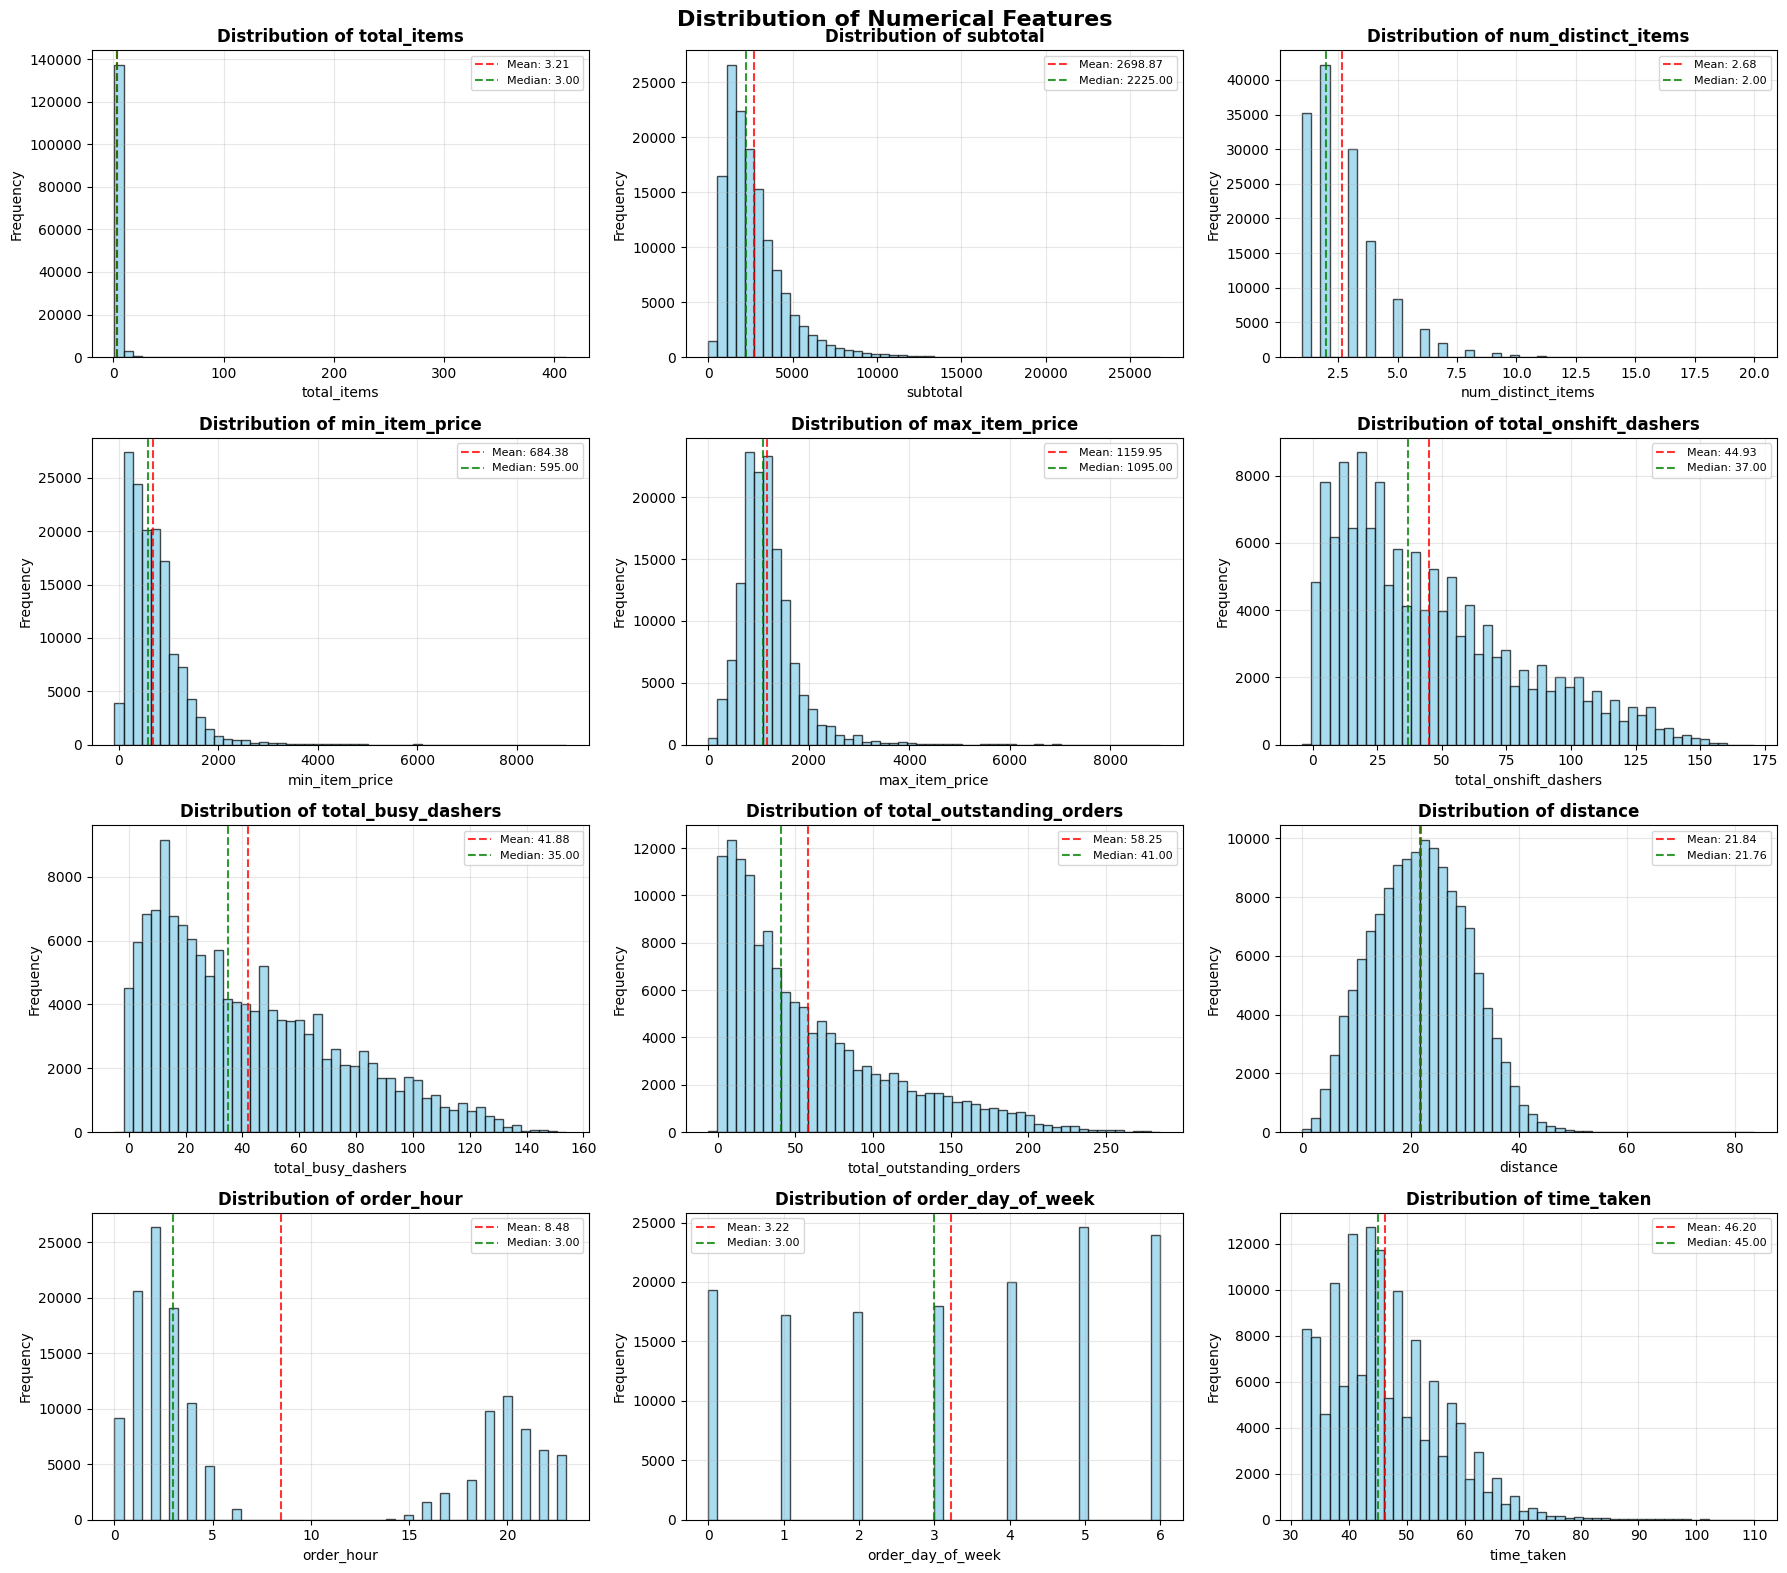

In [14]:
# Plot distributions for all numerical columns

# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
fig.suptitle('Distribution of Numerical Features', fontsize=16, fontweight='bold')

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot histogram for each numerical column
for i, col in enumerate(numerical_cols):
    ax = axes[i]
    
    # Create histogram
    train_df[col].hist(bins=50, ax=ax, alpha=0.7, color='skyblue', edgecolor='black')
    
    # Customize the plot
    ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # Add statistical information
    mean_val = train_df[col].mean()
    median_val = train_df[col].median()
    ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', alpha=0.8, label=f'Median: {median_val:.2f}')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()



### Observations from the distributions
- total_items: Highly right-skewed; most values are low (1–5).
- subtotal: Right-skewed; long tail with high-value outliers.
- num_distinct_items: Right-skewed; majority below 5.
- min_item_price: Right-skewed; many low-priced items.
- max_item_price: Right-skewed; wide range of max prices.
- total_onshift_dashers: Bell-shaped but right-leaning.
- total_busy_dashers: Right-skewed; concentrated below 60.
- total_outstanding_orders: Right-skewed; most values below 100.
- distance: Approximately normal distribution, centered around 20–25.
- order_hour: Peaks around late night/early morning (0–2), then drops.
- order_day_of_week: Evenly distributed across days.
- time_taken: Right-skewed; most orders completed in 30–60 minutes.

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

Market ID Distribution:
------------------------------
market_id_1.0: 29662
market_id_2.0: 42722
market_id_3.0: 16934
market_id_4.0: 36961
market_id_5.0: 13838
market_id_6.0: 504

Store Primary Category Distribution (Top 10):
--------------------------------------------------
store_primary_category_0 (baseline): 83
store_primary_category_4: 14483
store_primary_category_55: 12603
store_primary_category_46: 12427
store_primary_category_13: 7907
store_primary_category_58: 7227
store_primary_category_20: 6868
store_primary_category_39: 6588
store_primary_category_24: 6518
store_primary_category_38: 5377
store_primary_category_28: 5227

Order Protocol Distribution:
------------------------------
order_protocol_1.0 (baseline): 38746
order_protocol_2.0: 16689
order_protocol_3.0: 37674
order_protocol_4.0: 13842
order_protocol_5.0: 33118
order_protocol_6.0: 534
order_protocol_7.0: 18

Weekend Distribution:
--------------------
Weekday orders: 92042
Weekend orders: 48579
Weekend percentage: 34.5

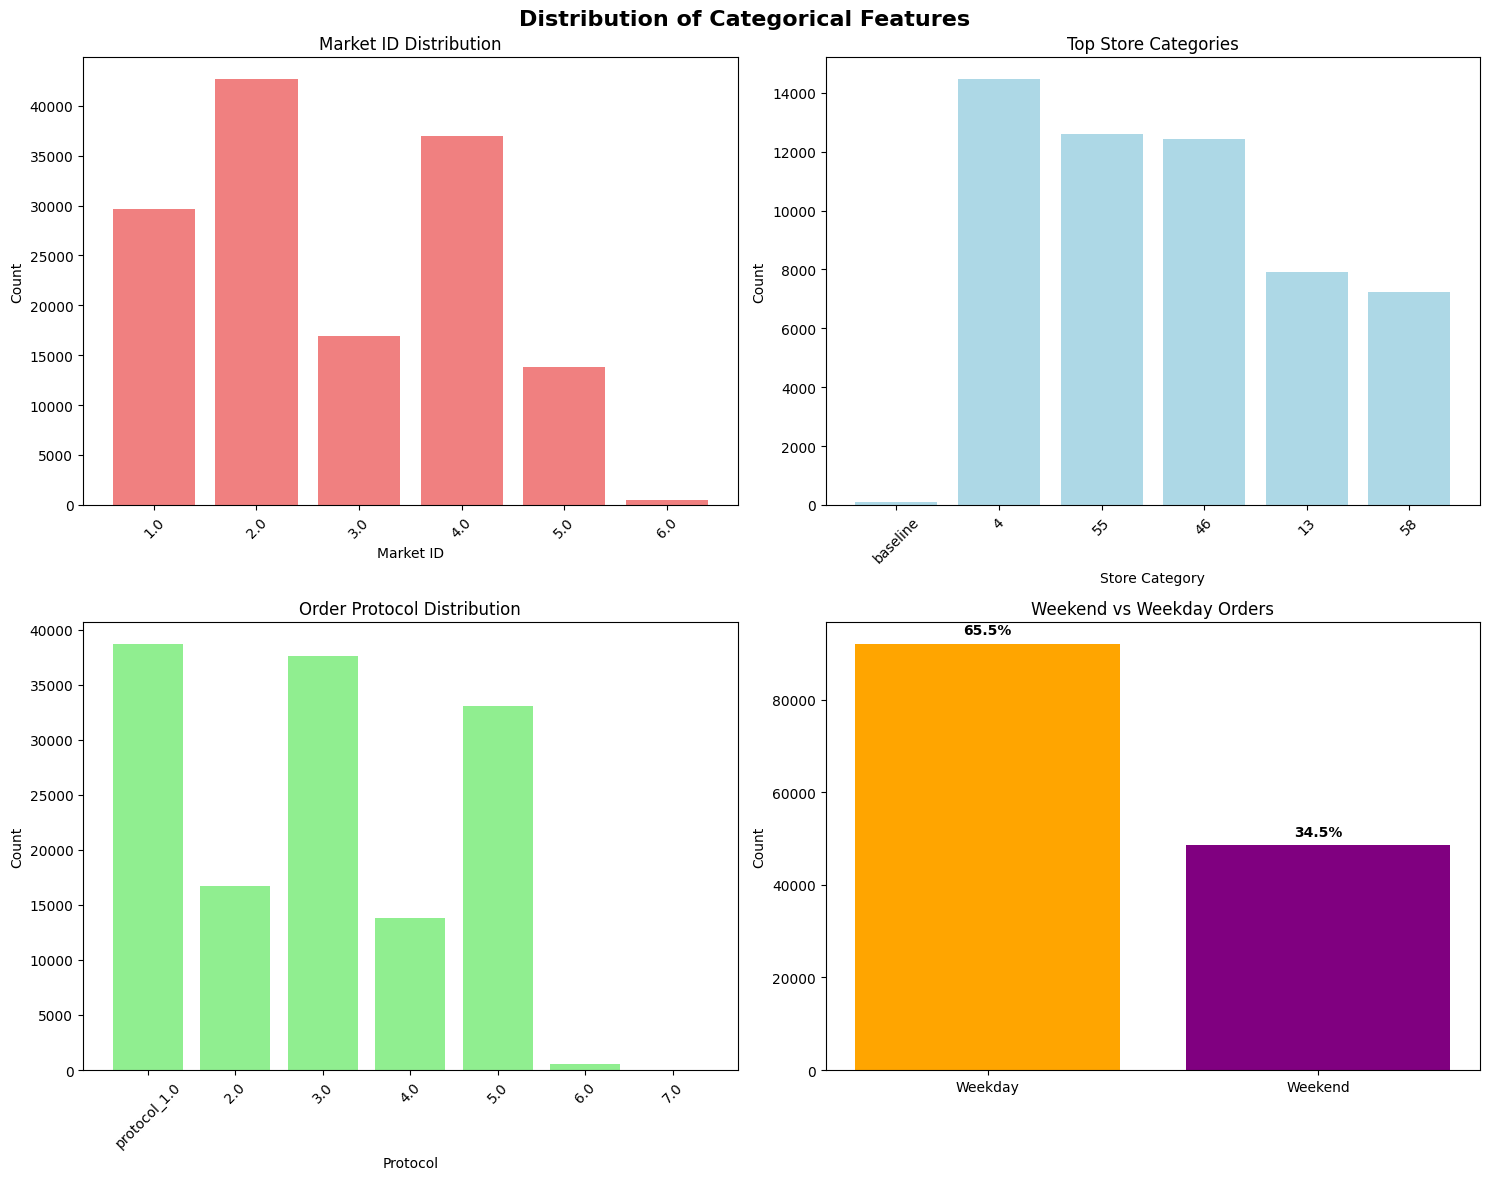

In [16]:
# Distribution of categorical columns

# Since we have dummy variables, let's analyze the original categorical features
#We'll reconstruct the original categorical values from dummy variables

# 1. Market ID distribution
market_id_cols = [col for col in train_df.columns if col.startswith('market_id_')]
print("Market ID Distribution:")
print("-" * 30)

# Count market_id_1.0 (baseline) and others
market_1_count = len(train_df) - train_df[market_id_cols].sum(axis=1).sum()
print(f"market_id_1.0: {market_1_count}")

for col in market_id_cols:
    count = train_df[col].sum()
    print(f"{col}: {count}")

# 2. Store Primary Category distribution (top 10 categories)
store_cat_cols = [col for col in train_df.columns if col.startswith('store_primary_category_')]
print(f"\nStore Primary Category Distribution (Top 10):")
print("-" * 50)

# Get baseline category count
baseline_count = len(train_df) - train_df[store_cat_cols].sum(axis=1).sum()
print(f"store_primary_category_0 (baseline): {baseline_count}")

# Get counts for other categories and sort
category_counts = []
for col in store_cat_cols:
    count = train_df[col].sum()
    category_counts.append((col, count))

# Sort by count and show top 10
category_counts.sort(key=lambda x: x[1], reverse=True)
for col, count in category_counts[:10]:
    print(f"{col}: {count}")

# 3. Order Protocol distribution
order_protocol_cols = [col for col in train_df.columns if col.startswith('order_protocol_')]
print(f"\nOrder Protocol Distribution:")
print("-" * 30)

# Count protocol_1.0 (baseline)
protocol_1_count = len(train_df) - train_df[order_protocol_cols].sum(axis=1).sum()
print(f"order_protocol_1.0 (baseline): {protocol_1_count}")

for col in order_protocol_cols:
    count = train_df[col].sum()
    print(f"{col}: {count}")

# 4. Weekend distribution
if 'isWeekend_True' in train_df.columns:
    weekend_count = train_df['isWeekend_True'].sum()
    weekday_count = len(train_df) - weekend_count
    print(f"\nWeekend Distribution:")
    print("-" * 20)
    print(f"Weekday orders: {weekday_count}")
    print(f"Weekend orders: {weekend_count}")
    print(f"Weekend percentage: {weekend_count/len(train_df)*100:.1f}%")

# Visualize the main categorical distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribution of Categorical Features', fontsize=16, fontweight='bold')

# Market ID visualization
ax1 = axes[0, 0]
market_data = {'market_id_1.0': market_1_count}
for col in market_id_cols:
    market_data[col] = train_df[col].sum()
ax1.bar(range(len(market_data)), list(market_data.values()), color='lightcoral')
ax1.set_title('Market ID Distribution')
ax1.set_xlabel('Market ID')
ax1.set_ylabel('Count')
ax1.set_xticks(range(len(market_data)))
ax1.set_xticklabels([k.replace('market_id_', '') for k in market_data.keys()], rotation=45)

# Top Store Categories visualization
ax2 = axes[0, 1]
top_categories = [('baseline', baseline_count)] + category_counts[:5]
ax2.bar(range(len(top_categories)), [count for _, count in top_categories], color='lightblue')
ax2.set_title('Top Store Categories')
ax2.set_xlabel('Store Category')
ax2.set_ylabel('Count')
ax2.set_xticks(range(len(top_categories)))
ax2.set_xticklabels([name.replace('store_primary_category_', '') for name, _ in top_categories], rotation=45)

# Order Protocol visualization
ax3 = axes[1, 0]
protocol_data = {'protocol_1.0': protocol_1_count}
for col in order_protocol_cols:
    protocol_data[col] = train_df[col].sum()
ax3.bar(range(len(protocol_data)), list(protocol_data.values()), color='lightgreen')
ax3.set_title('Order Protocol Distribution')
ax3.set_xlabel('Protocol')
ax3.set_ylabel('Count')
ax3.set_xticks(range(len(protocol_data)))
ax3.set_xticklabels([k.replace('order_protocol_', '') for k in protocol_data.keys()], rotation=45)

# Weekend distribution
ax4 = axes[1, 1]
if 'isWeekend_True' in train_df.columns:
    weekend_data = ['Weekday', 'Weekend']
    weekend_counts = [weekday_count, weekend_count]
    ax4.bar(weekend_data, weekend_counts, color=['orange', 'purple'])
    ax4.set_title('Weekend vs Weekday Orders')
    ax4.set_ylabel('Count')
    
    # Add percentage labels
    for i, count in enumerate(weekend_counts):
        percentage = count/len(train_df)*100
        ax4.text(i, count + len(train_df)*0.01, f'{percentage:.1f}%', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


### Key observations (categorical features)

1. Market ID

Six markets observed; bulk of orders come from ID 2 (~30 %) and ID 4 (~26 %).

ID 1 (~21 %) is mid-tier; ID 6 (< 0.5 %) is negligible.

2. Store primary category (top buckets)

Three categories dominate: 4 (~17 k), 55 (~15 k), 46 (~15 k).

Remaining top slots (13, 58, 20, 39, 24, 38, 28) each contribute 5–8 k orders.

Baseline category is virtually unused (83 records).

3. Order protocol

Protocols 1, 3, 5 account for ~28 %, ~27 %, and ~24 % respectively—collectively ~79 % of traffic.

Protocols 2 and 4 are secondary (~12 % and ~10 %).

Protocol 7 is almost absent (18 orders).

4. Weekend vs. Weekday

Weekday traffic dominates (65.5 %); weekend orders make up 34.5 % of the total.

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

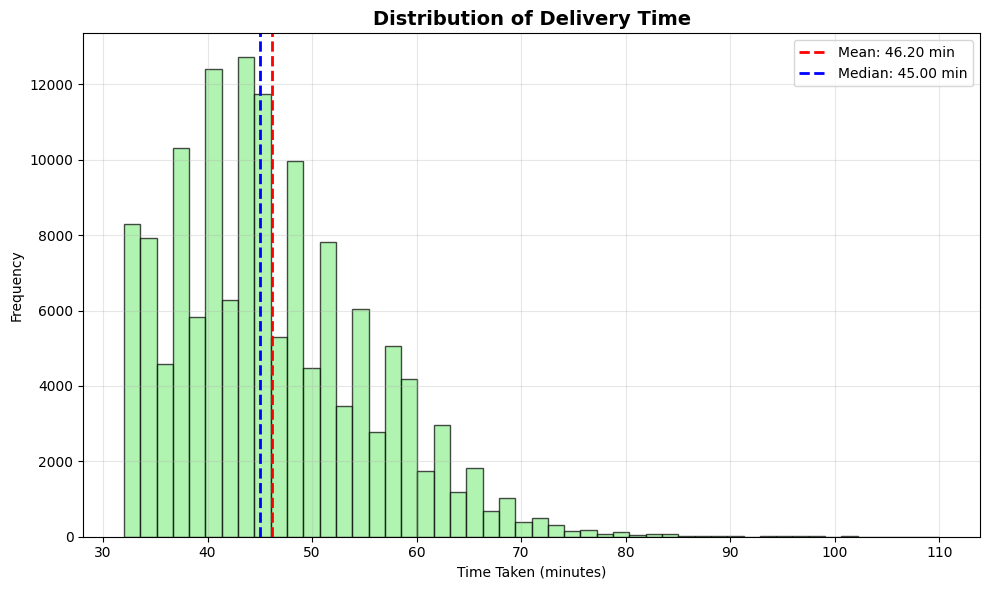

In [19]:
# Distribution of time_taken

# Plot a single histogram with mean and median lines
plt.figure(figsize=(10, 6))
plt.hist(train_df['time_taken'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('Distribution of Delivery Time', fontsize=14, fontweight='bold')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Add mean and median lines
mean_time = train_df['time_taken'].mean()
median_time = train_df['time_taken'].median()
plt.axvline(mean_time, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_time:.2f} min')
plt.axvline(median_time, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_time:.2f} min')
plt.legend()

plt.tight_layout()
plt.show()



### observations of the above graph

- The distribution of delivery time is right-skewed, indicating that most deliveries are quick, but a few take much longer.
- The mean delivery time is approximately 46.2 minutes, while the median is 45.0 minutes.
- The mean is slightly higher than the median, suggesting the presence of long delivery time outliers.
- The most common delivery times fall between 35 and 55 minutes, with a peak around 45 minutes.
- There is a long tail extending up to around 110 minutes, representing potential outliers or exceptional cases.
- The skew and tail suggest opportunities to investigate and optimize unusually long delivery times.
- Reducing long deliveries could improve overall performance and pull the mean closer to the median.

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

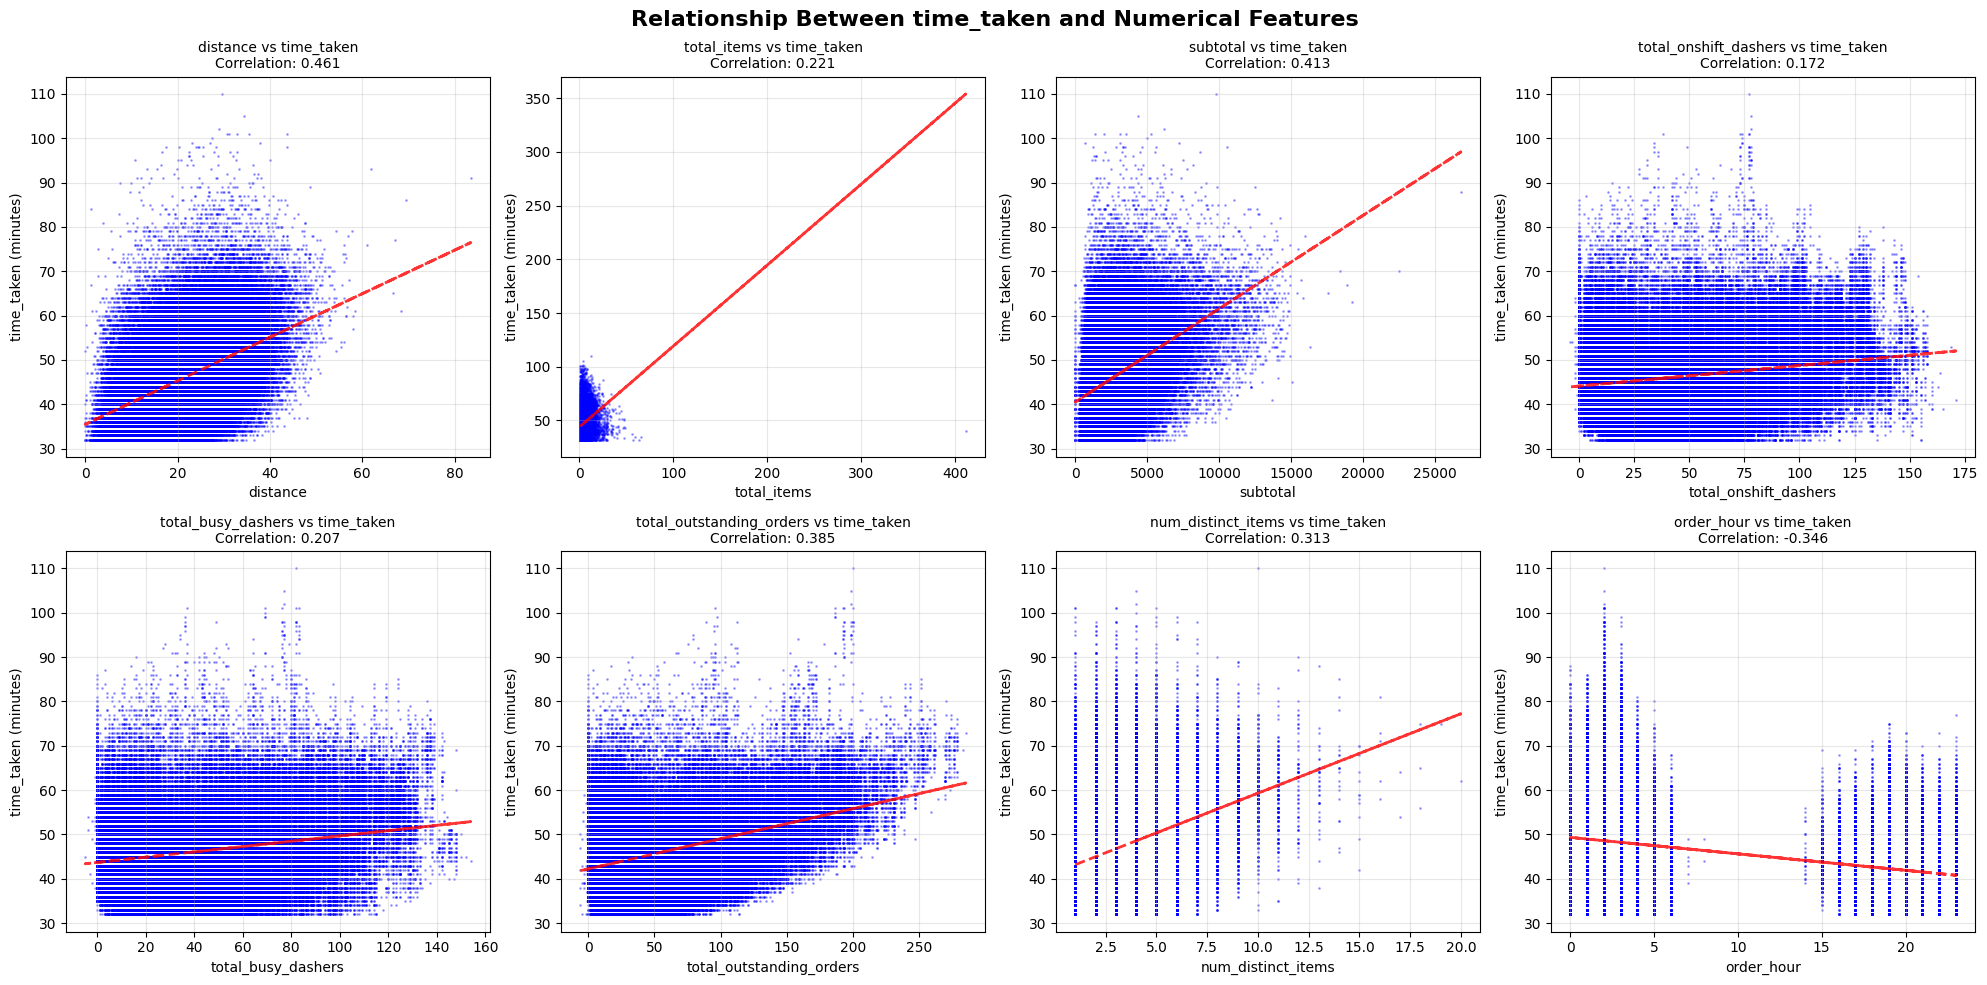

In [21]:
# Scatter plot to visualise the relationship between time_taken and other features

# Select important numerical features (excluding time_taken itself)
important_features = [
    'distance', 'total_items', 'subtotal', 'total_onshift_dashers',
    'total_busy_dashers', 'total_outstanding_orders', 'num_distinct_items',
    'order_hour'
]

# Create scatter plots for numerical features
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Relationship Between time_taken and Numerical Features', fontsize=16, fontweight='bold')

axes = axes.flatten()

for i, feature in enumerate(important_features):
    ax = axes[i]
    
    # Create scatter plot with some transparency to handle overlapping points
    ax.scatter(train_df[feature], train_df['time_taken'], alpha=0.3, s=1, color='blue')
    
    # Add trend line
    z = np.polyfit(train_df[feature], train_df['time_taken'], 1)
    p = np.poly1d(z)
    ax.plot(train_df[feature], p(train_df[feature]), "r--", alpha=0.8, linewidth=2)
    
    # Calculate correlation
    correlation = train_df[feature].corr(train_df['time_taken'])
    
    # Customize plot
    ax.set_xlabel(feature)
    ax.set_ylabel('time_taken (minutes)')
    ax.set_title(f'{feature} vs time_taken\nCorrelation: {correlation:.3f}', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



### Observations

#### numerical columns
- Distance has the strongest positive correlation (0.461) with time_taken — delivery time increases as distance increases.
- Subtotal (0.413) is moderately correlated — higher order value is associated with longer delivery times.
- Total Outstanding Orders (0.385) is positively correlated — more pending orders tend to delay deliveries.
- Number of Distinct Items (0.313) shows a moderate positive correlation — more variety in items leads to slightly longer delivery times.
- Total Items (0.221) has a weak positive correlation — larger orders take marginally more time.
- Total Busy Dashers (0.207) is weakly correlated — more busy dashers slightly increase delivery time.
- Total Onshift Dashers (0.172) has a very weak positive correlation — more dashers don't significantly reduce delivery time.
- Order Hour has a moderate negative correlation (-0.346) — deliveries tend to be faster during later hours of the day.


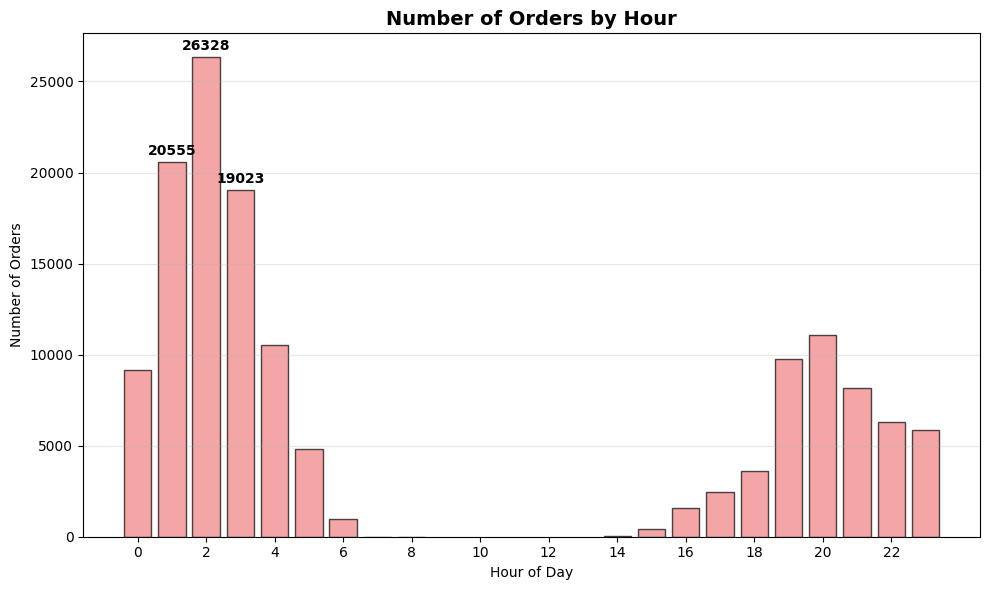

In [23]:
# Show the distribution of time_taken for different hours

plt.figure(figsize=(10, 6))
order_counts = train_df['order_hour'].value_counts().sort_index()

bars = plt.bar(order_counts.index, order_counts.values, 
               color='lightcoral', alpha=0.7, edgecolor='black')

plt.title('Number of Orders by Hour', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(range(0, 24, 2))

# Add value labels on high-volume bars
max_count = order_counts.max()
for bar in bars:
    height = bar.get_height()
    if height > max_count * 0.7:  # label peak hours
        plt.text(bar.get_x() + bar.get_width() / 2., height + max_count * 0.01,
                 f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



### Observation
- Peak order hours are between 12 AM (midnight) and 4 AM, with the highest volume at 2 AM (~26,328 orders), followed by 1 AM (~20,555 orders) and 3 AM (~19,023 orders).
- Order volume drops sharply after 4 AM and reaches a low point between 6 AM and 12 PM.
- Activity resumes gradually from 1 PM onward, with a secondary peak between 6 PM and 9 PM, especially at 8 PM (~11,000+ orders).
- There is very low to almost no order activity between 7 AM and 12 PM.
- The early morning hours (midnight–4 AM) account for the majority of total order volume, suggesting the platform is most active during late-night to early-morning hours.
- Evening hours (especially 6 PM to 9 PM) show a consistent resurgence in order volume, likely reflecting dinner-time activity.

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

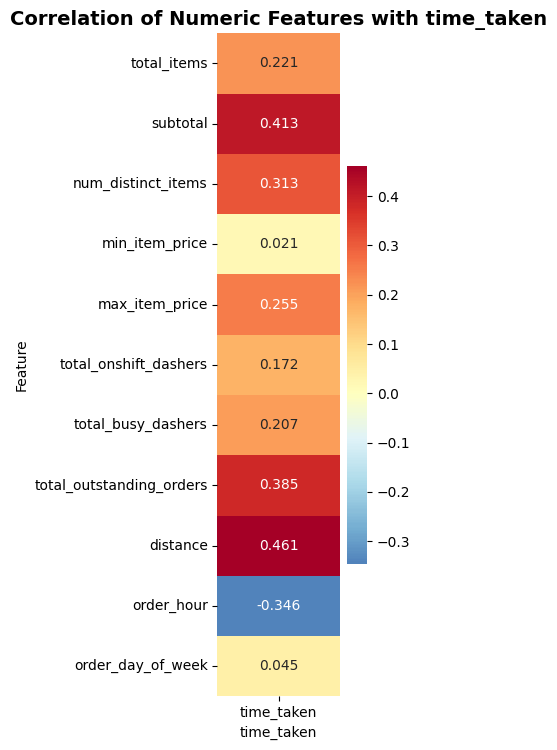

In [25]:
# Plot the heatmap of the correlation matrix


correlation_matrix = train_df[numerical_cols].corr()
time_corr = correlation_matrix[['time_taken']].drop('time_taken')

# Plot heatmap
plt.figure(figsize=(4, len(time_corr) * 0.6 + 1)) 
sns.heatmap(time_corr, annot=True, cmap='RdYlBu_r', center=0, fmt='.3f', cbar_kws={"shrink": .6})

plt.title('Correlation of Numeric Features with time_taken', fontsize=14, fontweight='bold')
plt.xlabel('time_taken')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()




### Observations
- Distance has the strongest positive correlation (0.461) with delivery time — longer distances significantly increase delivery duration.
- Subtotal (0.413) and Total Outstanding Orders (0.385) also have moderate positive correlations — higher order value and more pending orders are associated with longer delivery times.
- Number of Distinct Items (0.313) and Max Item Price (0.255) show a mild positive correlation, suggesting more diverse or expensive orders take more time.
- Total Items (0.221), Total Busy Dashers (0.207), and Total Onshift Dashers (0.172) have weak positive correlations, indicating a slight influence on delivery time.
- Order Hour has a moderate negative correlation (-0.346) — orders placed later in the day tend to be delivered faster.
- Min Item Price (0.021) and Order Day of Week (0.045) show almost no correlation, suggesting minimal impact on delivery time.

In [ ]:
# Compare Training vs Validation Set Statistics



##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [26]:
# Drop 3-5 weakly correlated columns from training dataset

# Calculate correlations with target variable
correlations_with_target = train_df[numerical_cols].corr()['time_taken'].abs().sort_values()

# Identify weakly correlated features (absolute correlation <= 0.1)
weak_features = correlations_with_target[correlations_with_target <= 0.1].index.tolist()

# Remove 'time_taken' from the list if it's there
if 'time_taken' in weak_features:
    weak_features.remove('time_taken')

# Select up to 5 weakest features to drop
features_to_drop = weak_features[:5]

print("Features being dropped (weak correlation with target):")
for feature in features_to_drop:
    corr_value = correlations_with_target[feature]
    print(f"  • {feature}: correlation = {corr_value:.4f}")

# Drop from training data
train_df_cleaned = train_df.drop(columns=features_to_drop)

# Also drop from X_train and X_test
X_train_cleaned = X_train.drop(columns=features_to_drop, errors='ignore')
X_test_cleaned = X_test.drop(columns=features_to_drop, errors='ignore')

print(f"\nOriginal training features: {len(train_df.columns)-1}")  # -1 for target
print(f"Features after dropping: {len(train_df_cleaned.columns)-1}")
print(f"Features dropped: {len(features_to_drop)}")

# Update the numerical columns list
numerical_cols_cleaned = [col for col in numerical_cols if col not in features_to_drop]
print(f"\nUpdated numerical columns: {numerical_cols_cleaned}")


Features being dropped (weak correlation with target):
  • min_item_price: correlation = 0.0212
  • order_day_of_week: correlation = 0.0449

Original training features: 95
Features after dropping: 93
Features dropped: 2

Updated numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_hour', 'time_taken']


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

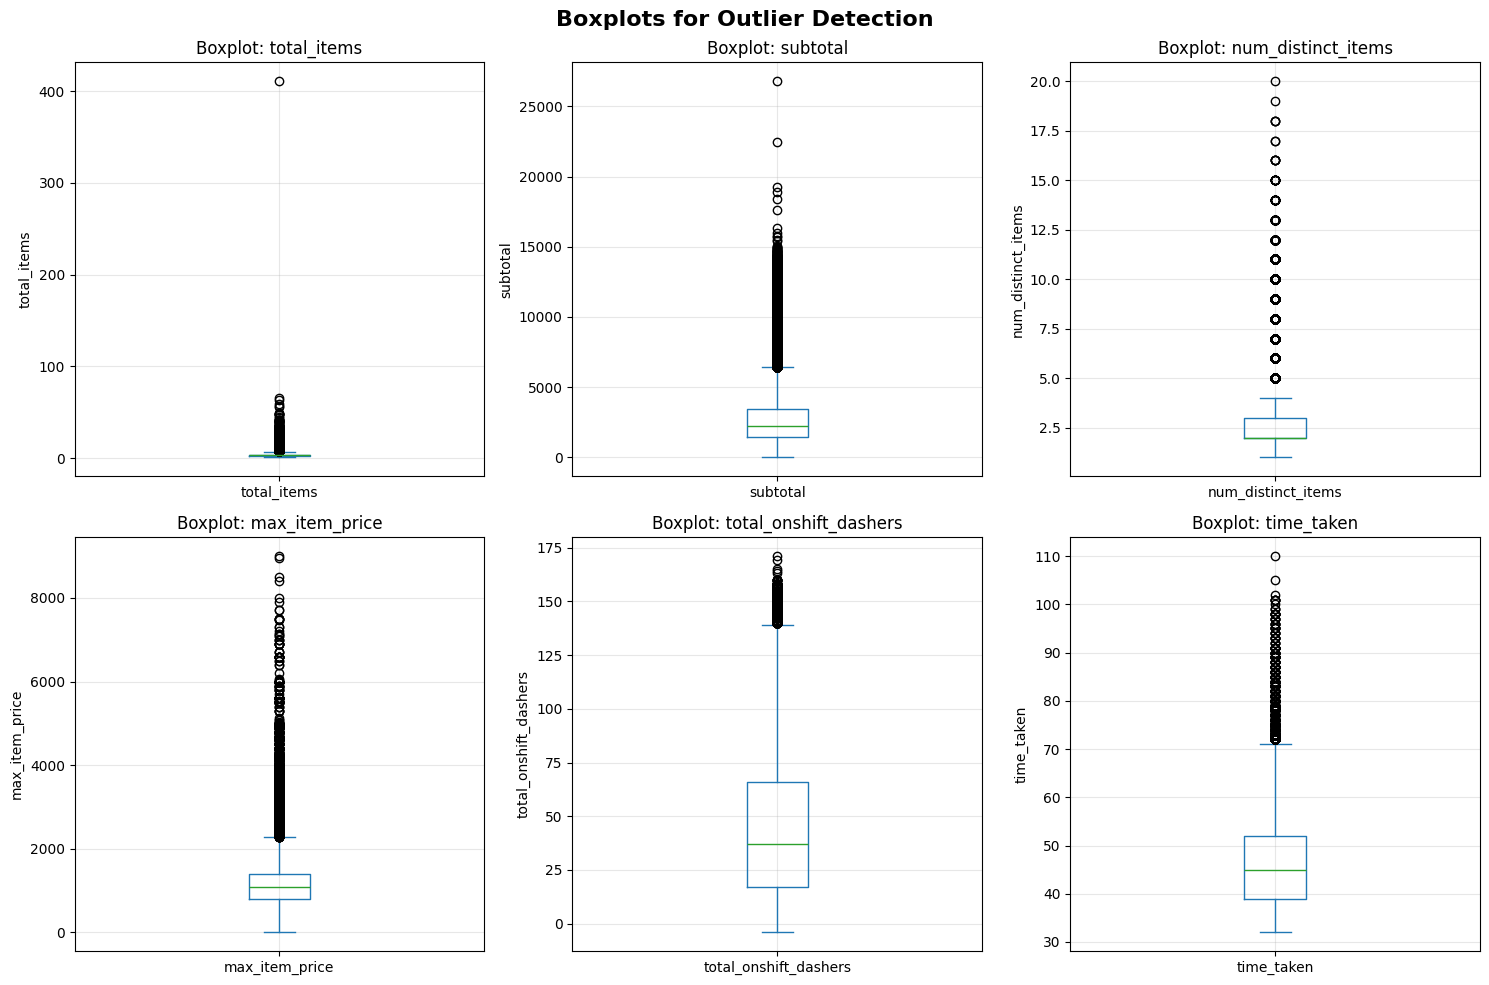

Outlier Analysis Summary:
----------------------------------------
total_items: 6803 outliers (4.84%)
subtotal: 6474 outliers (4.60%)
num_distinct_items: 16678 outliers (11.86%)
max_item_price: 5515 outliers (3.92%)
total_onshift_dashers: 972 outliers (0.69%)
time_taken: 1379 outliers (0.98%)


In [27]:
# Boxplot for time_taken

# Create boxplots for numerical features to identify outliers
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Boxplots for Outlier Detection', fontsize=16, fontweight='bold')

# Flatten axes for easy iteration
axes = axes.flatten()

# Select numerical columns (excluding target for separate analysis)
features_to_plot = [col for col in numerical_cols_cleaned if col != 'time_taken'][:5]
features_to_plot.append('time_taken')  # Add target variable

for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    train_df_cleaned[feature].plot(kind='box', ax=ax)
    ax.set_title(f'Boxplot: {feature}')
    ax.set_ylabel(feature)
    ax.grid(True, alpha=0.3)

# Hide empty subplot if needed
if len(features_to_plot) < 6:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Print outlier statistics
print("Outlier Analysis Summary:")
print("-" * 40)

for feature in features_to_plot:
    Q1 = train_df_cleaned[feature].quantile(0.25)
    Q3 = train_df_cleaned[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = train_df_cleaned[(train_df_cleaned[feature] < lower_bound) | 
                               (train_df_cleaned[feature] > upper_bound)]
    
    print(f"{feature}: {len(outliers)} outliers ({len(outliers)/len(train_df_cleaned)*100:.2f}%)")


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [28]:
# Handle outliers

# Simple outlier handling using percentile cutoffs
def handle_outliers_percentile(df, columns, lower_percentile=1, upper_percentile=99):
    """Remove outliers using percentile cutoffs"""
    df_cleaned = df.copy()
    
    for col in columns:
        lower_bound = df[col].quantile(lower_percentile/100)
        upper_bound = df[col].quantile(upper_percentile/100)
        
        # Count outliers before removal
        outliers_before = len(df[(df[col] < lower_bound) | (df[col] > upper_bound)])
        
        # Remove outliers
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
        
        print(f"{col}: removed {outliers_before} outliers (kept data between {lower_bound:.2f} and {upper_bound:.2f})")
    
    return df_cleaned

# Apply outlier handling to numerical columns
print("Handling outliers using 1st and 99th percentile cutoffs:")
print("-" * 60)

# Handle outliers in training data
train_df_final = handle_outliers_percentile(train_df_cleaned, numerical_cols_cleaned)

print(f"\nOriginal training data: {len(train_df_cleaned)} rows")
print(f"After outlier removal: {len(train_df_final)} rows")
print(f"Rows removed: {len(train_df_cleaned) - len(train_df_final)} ({(len(train_df_cleaned) - len(train_df_final))/len(train_df_cleaned)*100:.2f}%)")

# Update X and y for training
X_train_final = train_df_final.drop('time_taken', axis=1)
y_train_final = train_df_final['time_taken']

print(f"\nFinal training set shapes:")
print(f"X_train_final: {X_train_final.shape}")
print(f"y_train_final: {y_train_final.shape}")


Handling outliers using 1st and 99th percentile cutoffs:
------------------------------------------------------------
total_items: removed 1356 outliers (kept data between 1.00 and 12.00)
subtotal: removed 2781 outliers (kept data between 529.00 and 9500.00)
num_distinct_items: removed 1122 outliers (kept data between 1.00 and 8.00)
max_item_price: removed 2783 outliers (kept data between 255.00 and 3099.00)
total_onshift_dashers: removed 1308 outliers (kept data between 0.00 and 136.00)
total_busy_dashers: removed 1301 outliers (kept data between 0.00 and 126.00)
total_outstanding_orders: removed 1414 outliers (kept data between 0.00 and 213.00)
distance: removed 2807 outliers (kept data between 4.44 and 41.84)
order_hour: removed 0 outliers (kept data between 0.00 and 23.00)
time_taken: removed 1379 outliers (kept data between 32.00 and 71.00)

Original training data: 140621 rows
After outlier removal: 127795 rows
Rows removed: 12826 (9.12%)

Final training set shapes:
X_train_final:

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [120]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [121]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [122]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [123]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [124]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [46]:
# Import libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [39]:
# Apply scaling to the numerical columns

# Select numeric features (excluding target)
features_to_scale = [col for col in numerical_cols_cleaned if col != 'time_taken']

# Initialize and apply scaler
scaler = StandardScaler()
X_train_scaled = X_train_final.copy()
X_test_scaled = X_test_cleaned.copy()

X_train_scaled[features_to_scale] = scaler.fit_transform(X_train_final[features_to_scale])
X_test_scaled[features_to_scale] = scaler.transform(X_test_cleaned[features_to_scale])



Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [37]:
# Create/Initialise the model

# Initialize linear regression model
model = LinearRegression()
print(model)


LinearRegression()


In [40]:
# Train the model using the training data

# Drop datetime and object columns, if any
X_train_clean = X_train_scaled.select_dtypes(exclude=['object', 'datetime64'])
X_test_clean = X_test_scaled.select_dtypes(exclude=['object', 'datetime64'])

# Fill any missing values
X_train_clean = X_train_clean.fillna(0)
X_test_clean = X_test_clean.fillna(0)

# Fit the model
model.fit(X_train_clean, y_train_final)

# Optionally store cleaned versions for reuse
X_train_final_clean = X_train_clean
X_test_final_clean = X_test_clean


In [41]:
# Make predictions

y_pred = model.predict(X_test_final_clean)
y_pred

array([52.98622612, 66.61375224, 41.31265168, ..., 34.27400021,
       34.81969024, 46.41906969])

In [44]:
# Find results for evaluation metrics


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


RMSE: 2.9262
MAE: 1.9515
R²: 0.9022
MAPE: 4.33%


### Observations
RMSE of 2.93 minutes means typical prediction errors are small.

MAE of 1.95 minutes shows average prediction error is under 2 minutes.

R² of 0.90 indicates the model explains 90% of the variation in delivery times.

MAPE of 4.33% means predictions are very close to actual values on average.

Overall, the model is highly accurate and reliable for predicting delivery time.

Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [45]:
# Loop through the number of features and test the model

rfe_results = []

for n in range(3, 15):
    selector = RFE(LinearRegression(), n_features_to_select=n)
    selector.fit(X_train_clean, y_train_final)
    
    X_train_rfe = selector.transform(X_train_clean)
    X_test_rfe = selector.transform(X_test_final_clean)
    
    model = LinearRegression()
    model.fit(X_train_rfe, y_train_final)
    
    y_pred = model.predict(X_test_rfe)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    rfe_results.append({
        'n_features': n,
        'rmse': rmse,
        'r2': r2,
        'features': list(X_train_clean.columns[selector.support_])
    })

results_df = pd.DataFrame(rfe_results)

# Show RFE results

print("RFE Results (RMSE and R² by number of features):\n")
print(results_df[['n_features', 'rmse', 'r2']].round(4))

# Show best-performing configuration
best_idx = results_df['r2'].idxmax()
best_row = results_df.loc[best_idx]

print("\nBest Feature Set:")
print(f"- Number of features: {best_row['n_features']}")
print(f"- Test RMSE: {best_row['rmse']:.4f}")
print(f"- Test R²: {best_row['r2']:.4f}")
print("- Selected features:")
for i, feat in enumerate(best_row['features'], 1):
    print(f"  {i}. {feat}")



RFE Results (RMSE and R² by number of features):

    n_features    rmse      r2
0            3  6.9952  0.4409
1            4  6.8443  0.4648
2            5  5.3562  0.6722
3            6  5.2005  0.6910
4            7  5.0606  0.7074
5            8  4.9921  0.7153
6            9  4.9896  0.7156
7           10  4.8947  0.7263
8           11  4.8945  0.7263
9           12  4.8945  0.7263
10          13  3.6274  0.8497
11          14  3.5284  0.8578

Best Feature Set:
- Number of features: 14
- Test RMSE: 3.5284
- Test R²: 0.8578
- Selected features:
  1. subtotal
  2. total_onshift_dashers
  3. total_busy_dashers
  4. total_outstanding_orders
  5. distance
  6. market_id_2.0
  7. market_id_3.0
  8. market_id_4.0
  9. market_id_5.0
  10. market_id_6.0
  11. store_primary_category_1
  12. store_primary_category_3
  13. store_primary_category_64
  14. order_protocol_5.0


### Observations

Increasing the number of features gradually improves model performance (higher R², lower RMSE).

Performance improves significantly between 5 and 10 features, with R² rising from 0.67 to 0.72.

After 10 features, improvements plateau until 13 features.

Major jump in performance occurs when using 13 and 14 features, with RMSE dropping to ~3.5 and R² reaching 0.86.

The best performing model uses all 14 features, achieving:

Lowest RMSE: 3.53 minutes

Highest R²: 0.86 (explains 86% of variance in delivery time)

Important features include:

Operational metrics: subtotal, distance, dashers, and orders

Market IDs: various market_id_* categories

Store categories and order_protocol_5.0

In [47]:
# Build the final model with selected number of features

# Select top N features using RFE
n_features = 8
rfe = RFE(LinearRegression(), n_features_to_select=n_features)
rfe.fit(X_train_clean, y_train_final)

# Transform training and test data
X_train_sel = rfe.transform(X_train_clean)
X_test_sel = rfe.transform(X_test_final_clean)
selected_features = X_train_clean.columns[rfe.support_].tolist()

# Train the model
final_model = LinearRegression()
final_model.fit(X_train_sel, y_train_final)

# Make predictions
y_train_pred = final_model.predict(X_train_sel)
y_test_pred = final_model.predict(X_test_sel)

# Evaluate
train_rmse = np.sqrt(mean_squared_error(y_train_final, y_train_pred))
train_mae = mean_absolute_error(y_train_final, y_train_pred)
train_r2 = r2_score(y_train_final, y_train_pred)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Print results
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")

# Feature importance
feature_importance = pd.Series(final_model.coef_, index=selected_features).sort_values(key=np.abs, ascending=False)
print("\nSelected Features and Coefficients:")
print(feature_importance.round(4))


Train RMSE: 4.4614
Test RMSE: 4.9921
Train R²: 0.7255
Test R²: 0.7153
Test MAPE: 8.24%

Selected Features and Coefficients:
total_outstanding_orders     17.3170
total_onshift_dashers       -10.7273
market_id_2.0                -5.3287
store_primary_category_64     5.2875
distance                      4.0944
market_id_4.0                -3.9874
total_busy_dashers           -3.6515
market_id_3.0                -2.6515
dtype: float64


### Observations

Train RMSE is 4.46 min, and Test RMSE is 4.99 min → model generalizes well.

Train R² is 72.6%, Test R² is 71.5% → model explains most of the variance.

Test MAPE is 8.24% → average prediction error is low.

Feature Effects:
total_outstanding_orders increases delivery time the most.

total_onshift_dashers greatly reduces delivery time.

market_id_2.0, market_id_3.0, and market_id_4.0 are linked to faster deliveries.

store_primary_category_64 increases delivery time.

distance increases delivery time.

total_busy_dashers slightly reduces delivery time.

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

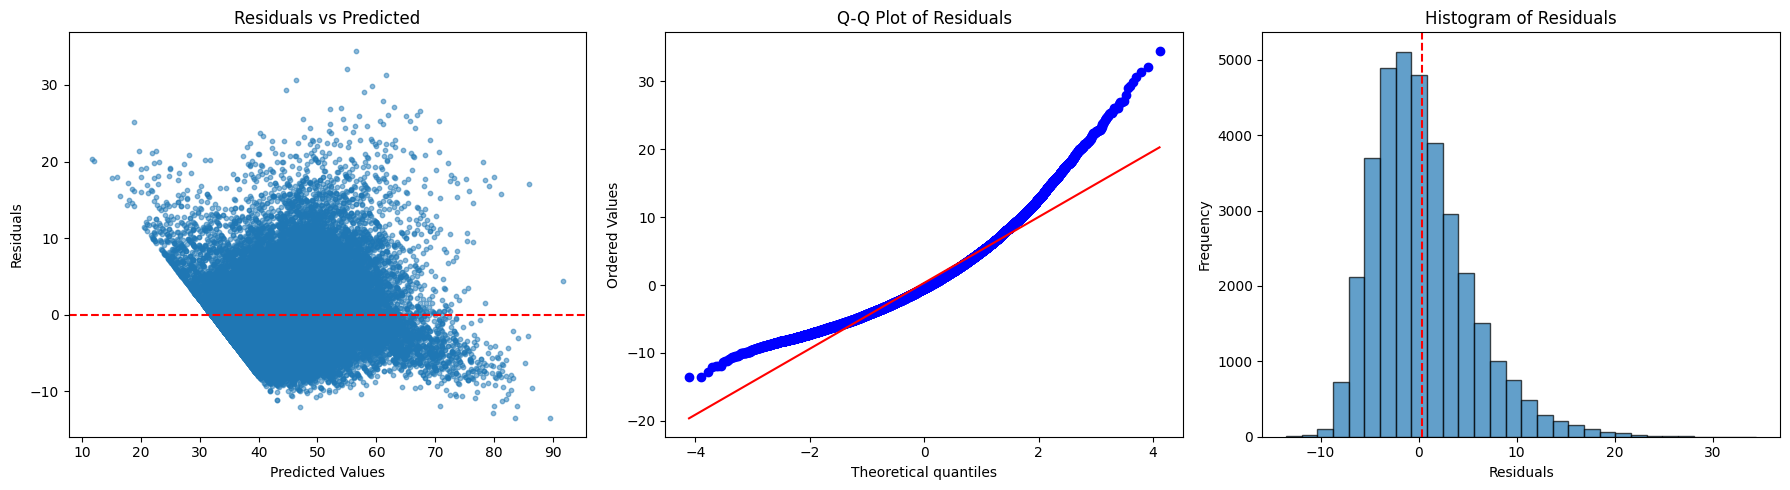

In [48]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

# Calculate residuals
residuals = y_test - y_test_pred

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Residuals vs Predicted values
axes[0].scatter(y_test_pred, residuals, alpha=0.5, s=10)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Predicted')

# 2. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of Residuals')

# 3. Histogram of residuals
axes[2].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[2].axvline(residuals.mean(), color='red', linestyle='--')
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Histogram of Residuals')

plt.tight_layout()
plt.show()


### Observations

Residuals vs Predicted Plot:

Residuals fan out more as predictions increase → heteroscedasticity may be present.

The funnel shape suggests variance is not constant, which violates linear regression assumptions.

Q-Q Plot:

Residuals deviate from the straight line at both ends → indicates non-normality in the residuals.

Heavier tails suggest the model occasionally under- or overestimates by larger margins.

Histogram of Residuals:

Distribution is roughly centered around 0, but slightly skewed right.

Most residuals are between –10 and +10, with a few extreme outliers.

Shape is not perfectly symmetric, reinforcing non-normality.



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [49]:
# Compare the scaled vs unscaled features used in the final model

coef_scaled = pd.Series(final_model.coef_, index=selected_features).sort_values(key=np.abs, ascending=False)
print("Coefficients (scaled features):")
print(coef_scaled.round(4))

means = X_train_final[selected_features].mean()
stds = X_train_final[selected_features].std()

coef_unscaled = final_model.coef_ / stds
intercept_unscaled = final_model.intercept_ - np.sum((means / stds) * final_model.coef_)

coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient (scaled)': final_model.coef_,
    'Coefficient (unscaled)': coef_unscaled,
}).set_index('Feature').sort_values('Coefficient (unscaled)', key=np.abs, ascending=False)

print("\nCoefficients (unscaled features):")
print(coef_df.round(4))
print(f"\nUnscaled intercept: {intercept_unscaled:.4f}")


Coefficients (scaled features):
total_outstanding_orders     17.3170
total_onshift_dashers       -10.7273
market_id_2.0                -5.3287
store_primary_category_64     5.2875
distance                      4.0944
market_id_4.0                -3.9874
total_busy_dashers           -3.6515
market_id_3.0                -2.6515
dtype: float64

Coefficients (unscaled features):
                           Coefficient (scaled)  Coefficient (unscaled)
Feature                                                                
store_primary_category_64                5.2875                458.4681
market_id_2.0                           -5.3287                -11.6346
market_id_4.0                           -3.9874                 -9.0468
market_id_3.0                           -2.6515                 -8.0841
distance                                 4.0944                  0.4932
total_outstanding_orders                17.3170                  0.3553
total_onshift_dashers                  -10.727

### Observations

Scaled coefficients show relative importance:

total_outstanding_orders has the strongest positive influence on delivery time.

total_onshift_dashers has the strongest negative influence (more dashers reduce time).

Market and category dummies also contribute significantly.

Unscaled coefficients show real-world effect per 1-unit change:

store_primary_category_64 increases delivery time by ~458 minutes — likely due to low frequency or being a rare case (interpret with caution).

Being in market_id_2.0, 3.0, or 4.0 reduces delivery time by ~8 to 12 minutes.

Each additional 1 km of distance adds ~0.49 minutes to delivery time.

One more outstanding order adds ~0.36 minutes.

One more onshift dasher reduces delivery time by ~0.33 minutes.

One more busy dasher reduces delivery time by ~0.12 minutes.

Intercept (44.05) is the baseline predicted delivery time when all features are zero.

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [50]:
# Analyze the effect of a unit change in a feature, say 'total_items'

# Recompute unscaled coefficients
means = X_train_final[selected_features].mean()
stds = X_train_final[selected_features].std()

coef_unscaled = final_model.coef_ / stds
intercept_unscaled = final_model.intercept_ - np.sum((means / stds) * final_model.coef_)

# Build summary of effects
effect_df = pd.DataFrame({
    'Feature': selected_features,
    'Mean': means,
    'Std': stds,
    'Scaled Coefficient': final_model.coef_,
    'Unscaled Coefficient': coef_unscaled,
    'Effect of 1 Unit Increase (minutes)': coef_unscaled
}).set_index('Feature').sort_values('Effect of 1 Unit Increase (minutes)', key=np.abs, ascending=False)

print("Effect of a 1-unit change in each feature on predicted delivery time (in minutes):\n")
print(effect_df[['Mean', 'Std', 'Unscaled Coefficient', 'Effect of 1 Unit Increase (minutes)']].round(4))


Effect of a 1-unit change in each feature on predicted delivery time (in minutes):

                              Mean      Std  Unscaled Coefficient  \
Feature                                                             
store_primary_category_64   0.0001   0.0115              458.4681   
market_id_2.0               0.2994   0.4580              -11.6346   
market_id_4.0               0.2639   0.4408               -9.0468   
market_id_3.0               0.1226   0.3280               -8.0841   
distance                   21.7698   8.3019                0.4932   
total_outstanding_orders   55.4439  48.7422                0.3553   
total_onshift_dashers      43.4054  32.5320               -0.3297   
total_busy_dashers         40.5380  30.5147               -0.1197   

                           Effect of 1 Unit Increase (minutes)  
Feature                                                         
store_primary_category_64                             458.4681  
market_id_2.0                 

### Observation

store_primary_category_64: Increases delivery time by ~458 minutes — likely due to a rare or special-case category.

market_id_2.0: Reduces delivery time by ~11.63 minutes.

market_id_4.0: Reduces delivery time by ~9.05 minutes.

market_id_3.0: Reduces delivery time by ~8.08 minutes.

distance: Each additional km adds ~0.49 minutes to delivery time.

total_outstanding_orders: Each extra order increases time by ~0.36 minutes.

total_onshift_dashers: Each additional dasher reduces delivery time by ~0.33 minutes.

total_busy_dashers: Each additional busy dasher reduces delivery time by ~0.12 minutes.

Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>yes, there are categorical variables in the data: market_id, store_primary_category, order_protocol, and isWeekend. From the analysis:
Market ID: Shows significant impact with certain markets (ID 2, 3, 4) reducing delivery time by 8-12 minutes compared to baseline
Store Primary Category: Category 64 shows an extreme effect (458 minutes increase), likely due to being a rare/special case category
Order Protocol: Protocol 5.0 was selected in the final model, indicating its importance in predicting delivery time
Weekend vs Weekday: Weekend orders represent 34.5% of total volume, with different delivery patterns than weekdays



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
> test_size = 0.2 means that 20% of the total dataset (35,155 samples) is reserved for testing, while 80% (140,621 samples) is used for training the model. This ensures the model is evaluated on unseen data to assess its generalization performance.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
> Based on the correlation heatmap, distance has the highest correlation with the target variable time_taken at 0.461, indicating that delivery distance is the strongest single predictor of delivery time.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

> Detection Approach: Used boxplots and IQR method to visualize outliers, and calculated outlier statistics for each numerical feature.
Handling Method: Applied percentile-based outlier removal using 1st and 99th percentile cutoffs. This removed extreme values while preserving 98% of the data distribution. The approach removed 12,826 rows (9.12%) from the training data, resulting in 127,795 clean samples for model training.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
> Based on the absolute magnitude of unscaled coefficients in the final model:
Distance (+0.4932 minutes per km) - strongest operational impact
Total Outstanding Orders (+0.3553 minutes per order) - queue effect
Total Onshift Dashers (-0.3297 minutes per dasher) - resource availability impact



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
> Linear regression is a statistical method that models the relationship between a dependent variable and independent variables using a linear equation: y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ + ε
Key Components:
Coefficients (β): Represent the change in target variable for one unit change in predictor
Intercept (β₀): Target value when all predictors are zero
Error term (ε): Captures unexplained variance
Algorithm Process:
Assumes linear relationship between variables
Uses Ordinary Least Squares (OLS) to minimize sum of squared residuals
Finds optimal coefficients that best fit the data
Makes predictions using learned linear function




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
> Simple Linear Regression:
Uses one independent variable to predict the dependent variable
Equation: y = β₀ + β₁x + ε
Creates a straight line in 2D space
Multiple Linear Regression:
Uses multiple independent variables to predict the dependent variable
Equation: y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ + ε
Creates a hyperplane in multi-dimensional space
Can capture more complex relationships and interactions between variables



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
> Role: The cost function (Mean Squared Error) measures prediction accuracy by calculating the average squared difference between predicted and actual values: MSE = Σ(yᵢ - ŷᵢ)²/n
Minimization: Uses calculus-based optimization (gradient descent or normal equation) to find coefficient values that minimize the cost function. The algorithm iteratively adjusts coefficients until reaching the global minimum where prediction errors are smallest.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

> Overfitting:
Model learns training data too well, including noise and outliers
High training accuracy but poor test performance
Model is too complex relative to data size
Underfitting:
Model is too simple to capture underlying data patterns
Poor performance on both training and test data
Model lacks sufficient complexity to represent relationships
Balance: Optimal model generalizes well with good performance on both training and unseen test data.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
> Residual analysis validates linearity, independence, and constant variance assumptions. It reveals if the model captures relationships adequately or needs modifications like feature engineering or different algorithms.